In [1]:
magma_dir = '/home/marco/epfl/magma/'

### **Config**

In [2]:
import os
import sys

sys.path.insert(0, magma_dir)
import config

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [3]:
MODEL = 'bart'
MODELS = {}

In [4]:
# Dataset path
data_dir = magma_dir + 'datasets/karger_books_para_wordembed/'+MODEL+'/'

# Output path
OUTPUT_PATH = magma_dir+'summarization/assign_bullets_para_wordembed/'+MODEL+'/'
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

### **Init**

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import re
import pandas as pd
from tqdm import tqdm
from textwrap import fill
tqdm.pandas()

### **Function Definition**

##### Import Model and Tok

In [6]:
def import_model_tok(model_name_or_path, verbose=False):
    global MODELS

    if model_name_or_path in MODELS.keys():
        if verbose : print('[+] model already present in cache\n')
        return MODELS[model_name_or_path]
    if verbose : print('[*] importing the model\n')

    if 'bart' in MODEL:
        from transformers import BartForConditionalGeneration, BartTokenizer

        model = BartForConditionalGeneration.from_pretrained(model_name_or_path)
        tokenizer = BartTokenizer.from_pretrained(model_name_or_path)
    elif 'pegasus' in MODEL:
        from transformers import PegasusForConditionalGeneration, PegasusTokenizer

        model = PegasusForConditionalGeneration.from_pretrained(model_name_or_path)
        tokenizer = PegasusTokenizer.from_pretrained(model_name_or_path)

    if verbose : print(model.config)
    MODELS[model_name_or_path] = model, tokenizer
    if verbose : print('[+] the model is now present in cache\n')
    return MODELS[model_name_or_path]

##### Print Examples

In [7]:
def print_examples(model_name_list, df, n_examples=10):
    
    df_examples = df.sample(n_examples, axis='index', random_state=config.SEED)
    
    for idx, row in df_examples.iterrows():
        print(idx)
        print(fill(row.text, 100))
        print()
        for model_name in model_name_list:
            model, tokenizer = import_model_tok(model_name)
            model = model.to(device)
            
            summ_enc = model.generate(
                tokenizer.encode(row.text, return_tensors='pt').to(device),
                min_length = config.ONE_BULLET_MIN_LEN,
                max_length = config.ONE_BULLET_MAX_LEN,
                length_penalty = config.LENGTH_PENALTY,
                num_beams = config.NUM_BEAMS,
                no_repeat_ngram_size = config.NO_REPEAT_NGRAM_SIZE,
                early_stopping = True)[0]
            summ_num_tok = len(summ_enc)
            summ = tokenizer.decode(summ_enc, skip_special_tokens=True)

            print('Prediction\n%s (%d tok):\n'%(model_name, summ_num_tok))
            print(fill(summ, 100))
            print()
            
        print('Reference:')
        print(fill(row.bullets, 100))
        print()
        print(''.join(['#']*100))
        print()

##### Plot Evaluation

In [8]:
def plot_evaluation(model_name_or_path):
    df = pd.read_csv(OUTPUT_PATH+model_name_or_path.replace('/', '?')+'.csv').set_index(['book', 'chapter'])

    prf = ['precision', 'recall', 'fmeasure']
    num_rouge = len(config.ROUGE_TYPES)

    from matplotlib.cm import get_cmap
    color = get_cmap('tab10')(range(num_rouge))
    def set_box_color(b, c):
        for k in b.keys():
            plt.setp(b[k], color=c)
    
    xticks = 2*np.array(np.arange(1, len(config.ROUGE_TYPES)+1))
    
    box_plt_list = []

    fig, ax = plt.subplots(figsize=(10, 6))
    for r, var in zip(prf, np.linspace(-0.15*num_rouge, 0.15*num_rouge, num_rouge)):
    
        box_plt_list.append(
            plt.boxplot(
            [df[rouge+'_'+r+'_'+model_name_or_path].tolist() for rouge in config.ROUGE_TYPES],
            positions= xticks+var,
            sym='+',
            widths=0.4,
            patch_artist=False,
            meanline=True,
            showmeans=True))

    for i, bp in enumerate(box_plt_list):
        set_box_color(bp, color[i])
        plt.plot([], c=color[i], label=prf[i])
    plt.legend()

    ax.grid(True, axis='y', alpha=0.7, linestyle='--')
    ax.set_title('Evaluation Results', fontsize='xx-large')
    ax.set_ylabel('Rouge', fontsize='x-large')
    plt.xticks(xticks, config.ROUGE_TYPES, fontsize='x-large')
    plt.show()

In [9]:
def plot_evaluation_bullet_by_bullet(model_name_or_path):
    df = pd.read_csv(OUTPUT_PATH+model_name_or_path.replace('/', '?')+\
        '_bullet_by_bullet.csv').set_index(['book', 'chapter'])

    prf = ['precision', 'recall', 'fmeasure']
    num_rouge = len(config.ROUGE_TYPES)

    from matplotlib.cm import get_cmap
    color = get_cmap('tab10')(range(num_rouge))
    def set_box_color(b, c):
        for k in b.keys():
            plt.setp(b[k], color=c)
    
    xticks = 2*np.array(np.arange(1, num_rouge+1))
    
    box_plt_list = []

    fig, ax = plt.subplots(figsize=(10, 6))
    for r, var in zip(prf, np.linspace(-0.15*num_rouge, 0.15*num_rouge, num_rouge)):
    
        box_plt_list.append(
            plt.boxplot(
            [df[rouge+'_'+r+'_'+model_name_or_path].tolist() for rouge in config.ROUGE_TYPES],
            positions= xticks+var,
            sym='+',
            widths=0.4,
            patch_artist=False,
            meanline=True,
            showmeans=True))

    for i, bp in enumerate(box_plt_list):
        set_box_color(bp, color[i])
        plt.plot([], c=color[i], label=prf[i])
    plt.legend()

    ax.grid(True, axis='y', alpha=0.7, linestyle='--')
    ax.set_title('Evaluation Results', fontsize='xx-large')
    ax.set_ylabel('Rouge', fontsize='x-large')
    plt.xticks(xticks, config.ROUGE_TYPES, fontsize='x-large')
    plt.show()

## **Sentence-Transformers**

In [10]:
data_dir_st = data_dir + 'st/'

In [11]:
df_train = pd.read_csv(data_dir_st + 'train.csv').set_index(['book', 'chapter'])
df_val = pd.read_csv(data_dir_st + 'val.csv').set_index(['book', 'chapter'])
df_test = pd.read_csv(data_dir_st + 'test.csv').set_index(['book', 'chapter'])

### **Print and Summarization**

##### Print Train Examples

In [20]:
print_examples([
    'sshleifer/distilbart-cnn-12-6',
    magma_dir+'fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_train/'],
    df_train)

(9781912776696, 'hh-5')
Kaplan-Meier curves provide a way of plotting the distribution of a time-to-event endpoint. In
Figure 2.1 the dashed line shows that at 24 months' follow-up the estimated survival probability is
54%. Kaplan-Meier survival curves are often used to compare the data between two groups of subjects.
Figure 2.2 shows Kaplan-Meier curves for OS in a randomized study of patients with human epidermal
growth factor receptor 2 (HER2)-positive metastatic breast cancer treated either with or without
trastuzumab. The Kaplan-Meier curve steps down at time points at which deaths occur, while censored
observations are denoted by notches on the curve. In this study, the follow-up period ranged from 3
months to 74 months.

Prediction
sshleifer/distilbart-cnn-12-6 (66 tok):
 Kaplan-Meier survival curves are often used to compare the data between two groups of subjects.
Figure 2.2 shows Kaplan-Meier curves for OS in a randomized study of patients with human epidermal
growth factor r

Prediction
sshleifer/distilbart-cnn-12-6 (47 tok):
 Neuropathic pain is initiated or caused by a primary lesion of the PNS or CNS. Patients often
complain not only of spontaneous pain, but also of pain from stimuli that are not normally painful
(allodynia)

Prediction
/home/marco/epfl/magma/fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_train/ (23 tok):
Neuropathic pain is initiated or caused by a primary lesion of the PNS or CNS.

Reference:
Neuropathic pain is produced by a lesion of the peripheral or central nervous system (CNS).

####################################################################################################

(9781910797662, 'ch03')
Delay in diagnosis. Although it is difficult to prove that delay in diagnosis affects prognosis,
screening for asymptomatic microscopic hematuria is associated with a shift towards more favorable
tumor characteristics of lower stage and grade at diagnosis, and better survival. Delays may occur
for a variety of

##### Print Val Examples

In [21]:
print_examples([
    'sshleifer/distilbart-cnn-12-6',
    magma_dir+'fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_train/'],
    df_val)

(9781908541178, 'ch_6')
Many anatomic factors can play a primary or a secondary role in the development and progression of
low back pain syndromes. The most common causes of low back pain are mechanical in origin.
Mechanical disorders of the lumbar spine are related to injury, overuse or deformity of a spinal
structure. The most important traumatic factors in low back pain relate to soft tissue structures.
Precise identification of the injured tissue, and the role of that injury in the consequent pain and
dysfunction, can be frustratingly difficult. Problems occur in muscles, intervertebral discs, facet
joints, ligaments or spinal nerves. Aging causes modification of these structures over time, and
different parts of the spine tend to be at greater risk for change or injury during different
decades of life. Early in life, muscle injuries are more frequent, while joint problems occur in the
sixth decade of life (Table 3.1).

Prediction
sshleifer/distilbart-cnn-12-6 (46 tok):
 Mechanical

Prediction
/home/marco/epfl/magma/fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_train/ (31 tok):
Tumors with high somatic mutation rates may be more susceptible to immuno-oncology therapies than
those with lower mutation rates.

Reference:
The potential sensitivity of a given cancer to immunotherapy depends on the immunogenicity of the
tumor, which is related to the somatic mutation rate within tumor cells.- The highest mutation rates
are seen in cancers of the skin, lung, bladder and stomach, rendering these tumor types more
sensitive to immunotherapy.

####################################################################################################

(9781910797471, 'ch02')
Advances in the management of heart failure (HF) over the past 20 years have been informed by a
better understanding of its pathophysiology. There are few situations in cardiology where treatment
has been as closely linked to an appreciation of the underlying science. Vicious cycle of hea

##### Print Test Examples

In [22]:
print_examples([
    'sshleifer/distilbart-cnn-12-6',
    magma_dir+'fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_train/'],
    df_test)

(9781908541277, 'ch_8')
Indications. OXC has a similar spectrum of efficacy to CBZ against partial and tonic-clonic
seizures. It tends to be better tolerated than CBZ with fewer neurotoxic side effects. Dosage. The
recommended starting dose for OXC in adults is 150-600 mg daily in two doses. The dose can be
titrated upwards as clinically indicated to 3000-4000 mg daily. A starting dose of 5 mg/kg daily in
children over 3 years of age can be prescribed, increasing gradually to a maintenance dose of about
30 mg/kg daily. Patients already on CBZ may be switched immediately to OXC using a dosage ratio of
1.5 OXC to 1 CBZ. Particular care in immediate switching needs to be taken when the daily CBZ dose
exceeds 1200 mg. Plasma concentrations of the clinically active metabolite of OXC increase linearly
with dose. No studies, however, have attempted to relate elevated plasma levels to efficacy or
toxicity.

Prediction
sshleifer/distilbart-cnn-12-6 (41 tok):
 OXC has a similar spectrum of effic

Prediction
/home/marco/epfl/magma/fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_train/ (45 tok):
Overweight/obesity as a whole predisposes to, or is associated with, numerous cardiac complications
such as coronary heart disease (CHD), atrial fibrillation, heart failure and sudden cardiac death.

Reference:
Obesity significantly affects cardiometabolic status and risk.

####################################################################################################

(9781908541024, 'ch_12')
The vast majority of primary brain tumors occur sporadically, but a small number appear to be
familial. The etiology of sporadic brain tumors is unknown, but environmental factors are suspected.
Most patients with a family history of primary brain tumors have a hereditary disease that is known
to be associated with such tumors, such as tuberous sclerosis, neurofibromatosis, familial polyposis
or Li-Fraumeni syndrome. However, some patients do not have any underlying or obv

Prediction
sshleifer/distilbart-cnn-12-6 (59 tok):
 All the possibilities highlighted in Table 12.1 must be entertained and discarded before
considering the headache to be caused by a chronic headache condition. Brain imaging, including
neurovascular studies, may be needed as well as cerebrospinal fluid (CSF) pressure measurement and
analysis.

Prediction
/home/marco/epfl/magma/fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_train/ (32 tok):
Brain imaging, including neurovascular studies, may be needed as well as cerebrospinal fluid (CSF)
pressure measurement and analysis.

Reference:
In patients without history of chronic headaches, determine whether an acute new headache is a
serious, potentially life-threatening condition.

####################################################################################################



##### Summarize Test

In [12]:
def summarize(model_name_or_path, df, batch_size):
    model, tokenizer = import_model_tok(model_name_or_path)
    model = model.to(device)

    input_ids = tokenizer(df.text.tolist(), return_tensors='pt', padding=True).input_ids
    input_ids = input_ids.split(batch_size)

    summs = []

    pbar = tqdm(total=len(input_ids), 
                position=0,
                leave=True,
                file=sys.stdout)
    for batch in input_ids:

        summ_enc = model.generate(
            batch.to(device),
            min_length = config.ONE_BULLET_MIN_LEN,
            max_length = config.ONE_BULLET_MAX_LEN,
            length_penalty = config.LENGTH_PENALTY,
            num_beams = config.NUM_BEAMS,
            no_repeat_ngram_size = config.NO_REPEAT_NGRAM_SIZE,
            early_stopping = True)
        summ = tokenizer.batch_decode(summ_enc, skip_special_tokens=True)
        summs += summ

        pbar.update(1)
    pbar.close()

    df['summary_'+model_name_or_path] = summs

    return df

In [13]:
df_test = summarize('sshleifer/distilbart-cnn-12-6', df_test, 10)
df_test = summarize(
    magma_dir+'fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_train/',
    df_test, 10)

100%|██████████| 25/25 [2:11:22<00:00, 315.29s/it]  


### **Evaluation**

In [14]:
from datasets import load_metric

metric = load_metric("rouge")

#### Evaluate summaries

In [15]:
def evaluate_model(df, model_name_or_path):
    df_eval = df.groupby(['book', 'chapter'], sort=False).agg({
        'text': lambda t: ' '.join(list(t)),
        'bullets': lambda b: ' '.join(list(b)),
        'summary_'+model_name_or_path: lambda s: ' '.join(list(s))})
    
    rouge_res =\
        df_eval[['bullets', 'summary_'+model_name_or_path]]\
        .apply(lambda row:
        metric.compute(
            predictions = [row[1]],
            references = [row[0]],
            rouge_types = config.ROUGE_TYPES,
            use_agregator = False), axis=1)

    for r in config.ROUGE_TYPES:
        for i, prf in enumerate(['precision', 'recall', 'fmeasure']):
            df_eval[r+'_'+prf+'_'+model_name_or_path] =\
                rouge_res.map(lambda score: score[r][0][i])
            
    df_eval.to_csv(OUTPUT_PATH+model_name_or_path.replace('/', '?')+'.csv')
    
    return df_eval

In [16]:
evaluate_model(df_test, 'sshleifer/distilbart-cnn-12-6')

,,text,bullets,summary_sshleifer/distilbart-cnn-12-6,rouge1_precision_sshleifer/distilbart-cnn-12-6,rouge1_recall_sshleifer/distilbart-cnn-12-6,rouge1_fmeasure_sshleifer/distilbart-cnn-12-6,rouge2_precision_sshleifer/distilbart-cnn-12-6,rouge2_recall_sshleifer/distilbart-cnn-12-6,rouge2_fmeasure_sshleifer/distilbart-cnn-12-6,rougeL_precision_sshleifer/distilbart-cnn-12-6,rougeL_recall_sshleifer/distilbart-cnn-12-6,rougeL_fmeasure_sshleifer/distilbart-cnn-12-6
book,chapter,,,,,,,,,,,,
9781910797631,chp6,Prevention and management. By far the most res...,The treatment rather than the prevention of de...,Preventive strategies may be directed toward ...,0.366337,0.430233,0.395722,0.064677,0.076023,0.069892,0.168317,0.197674,0.181818
9781910797426,ch03,Epidemiology and risk factors. Gallstones are ...,The prevalence of gallstones is greater in peo...,Gallstones are a significant cause of morbidi...,0.461929,0.710938,0.560000,0.239796,0.370079,0.291022,0.324873,0.500000,0.393846
9781908541277,ch_12,Nearly 1 in 3 patients reports significant con...,Depression and anxiety are common in patients ...,Depression is the most prevalent psychiatric ...,0.264407,0.523490,0.351351,0.078231,0.155405,0.104072,0.132203,0.261745,0.175676
9781910797907,chp6,When to transfuse. There is no set standard wi...,The decision for transfusion therapy relates t...,There is no set standard with regard to trans...,0.394118,0.511450,0.445183,0.153846,0.200000,0.173913,0.258824,0.335878,0.292359
9781908541277,ch_8,Modern antiepileptic drugs. After a hiatus of ...,Sixteen new antiepileptic drugs (AEDs) have be...,16 new AEDs and two devices - the vagus nerve...,0.171875,0.423077,0.244444,0.031496,0.078431,0.044944,0.125000,0.307692,0.177778
9781910797006,ch08,Acute exacerbations of chronic obstructive pul...,Acute exacerbations of COPD are common and pla...,"In the UK, respiratory admissions account for...",0.204461,0.617978,0.307263,0.070896,0.215909,0.106742,0.107807,0.325843,0.162011
9781910797105,ch06,Morphological findings. MRI studies confirmed ...,People with schizophrenia exhibit gray matter ...,People with schizophrenia exhibit decreased v...,0.234375,0.728155,0.354610,0.150470,0.470588,0.228029,0.203125,0.631068,0.307329
9783318068207,hh-5,The recent improvements in terms of available ...,Comprehensive genomic profiles offer a complet...,The adoption of broad NGS gene panels may sup...,0.239544,0.516393,0.327273,0.057252,0.123967,0.078329,0.140684,0.303279,0.192208
9781910797105,ch04,Studies in twins involve probands with schizop...,Identical twins show a 45% concordance rate. H...,MZ twins share 100% of their genes and DZ twi...,0.216216,0.563380,0.312500,0.032609,0.085714,0.047244,0.102703,0.267606,0.148438


In [17]:
evaluate_model(df_test,
    magma_dir+'fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_train/')

,,text,bullets,summary_/home/marco/epfl/magma/fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_train/,rouge1_precision_/home/marco/epfl/magma/fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_train/,rouge1_recall_/home/marco/epfl/magma/fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_train/,rouge1_fmeasure_/home/marco/epfl/magma/fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_train/,rouge2_precision_/home/marco/epfl/magma/fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_train/,rouge2_recall_/home/marco/epfl/magma/fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_train/,rouge2_fmeasure_/home/marco/epfl/magma/fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_train/,rougeL_precision_/home/marco/epfl/magma/fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_train/,rougeL_recall_/home/marco/epfl/magma/fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_train/,rougeL_fmeasure_/home/marco/epfl/magma/fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_train/
book,chapter,,,,,,,,,,,,
9781910797631,chp6,Prevention and management. By far the most res...,The treatment rather than the prevention of de...,Prevention and management of depression may be...,0.446970,0.343023,0.388158,0.099237,0.076023,0.086093,0.219697,0.168605,0.190789
9781910797426,ch03,Epidemiology and risk factors. Gallstones are ...,The prevalence of gallstones is greater in peo...,Gallstones are a significant cause of morbidit...,0.520000,0.406250,0.456140,0.202020,0.157480,0.176991,0.300000,0.234375,0.263158
9781908541277,ch_12,Nearly 1 in 3 patients reports significant con...,Depression and anxiety are common in patients ...,Depression is the most prevalent psychiatric c...,0.459459,0.570470,0.508982,0.233696,0.290541,0.259036,0.335135,0.416107,0.371257
9781910797907,chp6,When to transfuse. There is no set standard wi...,The decision for transfusion therapy relates t...,There is no set standard with regard to transf...,0.648936,0.465649,0.542222,0.268817,0.192308,0.224215,0.329787,0.236641,0.275556
9781908541277,ch_8,Modern antiepileptic drugs. After a hiatus of ...,Sixteen new antiepileptic drugs (AEDs) have be...,"After a hiatus of nearly 20 years, 16 new AEDs...",0.281690,0.384615,0.325203,0.057143,0.078431,0.066116,0.211268,0.288462,0.243902
9781910797006,ch08,Acute exacerbations of chronic obstructive pul...,Acute exacerbations of COPD are common and pla...,Acute exacerbations of chronic obstructive pul...,0.338583,0.483146,0.398148,0.158730,0.227273,0.186916,0.204724,0.292135,0.240741
9781910797105,ch06,Morphological findings. MRI studies confirmed ...,People with schizophrenia exhibit gray matter ...,People with schizophrenia exhibit decreased vo...,0.357542,0.621359,0.453901,0.174157,0.303922,0.221429,0.296089,0.514563,0.375887
9783318068207,hh-5,The recent improvements in terms of available ...,Comprehensive genomic profiles offer a complet...,The adoption of broad NGS gene panels may supp...,0.272727,0.344262,0.304348,0.032680,0.041322,0.036496,0.142857,0.180328,0.159420
9781910797105,ch04,Studies in twins involve probands with schizop...,Identical twins show a 45% concordance rate. H...,MZ twins share 100% of their genes and DZ twin...,0.235294,0.338028,0.277457,0.039604,0.057143,0.046784,0.127451,0.183099,0.150289


#### Evaluate summaries bullet by bullet

In [18]:
def evaluate_model_bullet_by_bullet(df, model_name_or_path):
    df_eval = df.copy()
    
    rouge_res =\
        df_eval[['bullets', 'summary_'+model_name_or_path]]\
        .apply(lambda row:
        metric.compute(
            predictions = [row[1]],
            references = [row[0]],
            rouge_types = config.ROUGE_TYPES,
            use_agregator = False), axis=1)

    for r in config.ROUGE_TYPES:
        for i, prf in enumerate(['precision', 'recall', 'fmeasure']):
            df_eval[r+'_'+prf+'_'+model_name_or_path] =\
                rouge_res.map(lambda score: score[r][0][i])
            
    df_eval.to_csv(OUTPUT_PATH+model_name_or_path.replace('/', '?')+'_bullet_by_bullet.csv')
    
    return df_eval

In [19]:
evaluate_model_bullet_by_bullet(df_test, 'sshleifer/distilbart-cnn-12-6')

bullets  \
book          chapter                                                      
9781910797631 chp6     The treatment rather than the prevention of de...   
              chp6     For milder forms of depression, self-help, rel...   
              chp6     There are a range of treatments that may be ef...   
              chp6     Selective serotonin-reuptake inhibitor antidep...   
              chp6     Depression is complex, and understanding and h...   
...                                                                  ...   
9781908541680 ch_4     Obesity significantly affects cardiometabolic ...   
              ch_4     Lipid disorders and hypertension are exacerbat...   
              ch_4     Weight loss rapidly and effectively reduces ca...   
              ch_4     The metabolic syndrome defines the clustering ...   
              ch_4     Type 2 diabetes mellitus is the comorbidity mo...   

                                                                    text  \
book          chapter                                                      
9781910797631 chp6     Prevention and management. By far the most res...   
              chp6     The forms of psychological therapy best suppor...   
              chp6     The effectiveness of individual treatments is ...   
              chp6     Monitoring use of antidepressants. For people ...   
              chp6     Suicidal ideas and acts may be increased in th...   
...                                                                  ...   
9781908541680 ch_4     Overweight/obesity as a whole predisposes to, ...   
              ch_4     Overweight/obesity as a whole predisposes to, ...   
              ch_4     Overweight/obesity as a whole predisposes to, ...   
              ch_4     'Metabolic syndrome' describes the clustering ...   
              ch_4     Type 2 diabetes mellitus is a preventable dise...   

                       num_bulls  \
book          chapter              
9781910797631 chp6          2319   
              chp6          2319   
              chp6          2319   
              chp6          2319   
              chp6          2319   
...                          ...   
9781908541680 ch_4          2556   
              ch_4          2556   
              ch_4          2556   
              ch_4          2556   
              ch_4          2556   

                                   summary_sshleifer/distilbart-cnn-12-6  \
book          chapter                                                      
9781910797631 chp6      Preventive strategies may be directed toward ...   
              chp6      The forms of psychological therapy best suppo...   
              chp6      Current evidence suggests that better outcome...   
              chp6      Many people discontinue their antidepressant ...   
              chp6      Suicidal ideas and acts may be increased in t...   
...                                                                  ...   
9781908541680 ch_4      Obesity is associated with hypertension, tach...   
              ch_4      Obesity is associated with hypertension, tach...   
              ch_4      Obesity is associated with hypertension, tach...   
              ch_4      The International Diabetes Federation updated...   
              ch_4      A modest reduction in weight by intensive lif...   

                      summary_/home/marco/epfl/magma/fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_train/  \
book          chapter                                                                                                               
9781910797631 chp6     Prevention and management of depression may be...                                                            
              chp6     The forms of psychological therapy best suppor...                                                            
              chp6     Stepped care is a model of healthcare based on...                         

In [20]:
evaluate_model_bullet_by_bullet(df_test,
    magma_dir+'fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_train/')

bullets  \
book          chapter                                                      
9781910797631 chp6     The treatment rather than the prevention of de...   
              chp6     For milder forms of depression, self-help, rel...   
              chp6     There are a range of treatments that may be ef...   
              chp6     Selective serotonin-reuptake inhibitor antidep...   
              chp6     Depression is complex, and understanding and h...   
...                                                                  ...   
9781908541680 ch_4     Obesity significantly affects cardiometabolic ...   
              ch_4     Lipid disorders and hypertension are exacerbat...   
              ch_4     Weight loss rapidly and effectively reduces ca...   
              ch_4     The metabolic syndrome defines the clustering ...   
              ch_4     Type 2 diabetes mellitus is the comorbidity mo...   

                                                                    text  \
book          chapter                                                      
9781910797631 chp6     Prevention and management. By far the most res...   
              chp6     The forms of psychological therapy best suppor...   
              chp6     The effectiveness of individual treatments is ...   
              chp6     Monitoring use of antidepressants. For people ...   
              chp6     Suicidal ideas and acts may be increased in th...   
...                                                                  ...   
9781908541680 ch_4     Overweight/obesity as a whole predisposes to, ...   
              ch_4     Overweight/obesity as a whole predisposes to, ...   
              ch_4     Overweight/obesity as a whole predisposes to, ...   
              ch_4     'Metabolic syndrome' describes the clustering ...   
              ch_4     Type 2 diabetes mellitus is a preventable dise...   

                       num_bulls  \
book          chapter              
9781910797631 chp6          2319   
              chp6          2319   
              chp6          2319   
              chp6          2319   
              chp6          2319   
...                          ...   
9781908541680 ch_4          2556   
              ch_4          2556   
              ch_4          2556   
              ch_4          2556   
              ch_4          2556   

                                   summary_sshleifer/distilbart-cnn-12-6  \
book          chapter                                                      
9781910797631 chp6      Preventive strategies may be directed toward ...   
              chp6      The forms of psychological therapy best suppo...   
              chp6      Current evidence suggests that better outcome...   
              chp6      Many people discontinue their antidepressant ...   
              chp6      Suicidal ideas and acts may be increased in t...   
...                                                                  ...   
9781908541680 ch_4      Obesity is associated with hypertension, tach...   
              ch_4      Obesity is associated with hypertension, tach...   
              ch_4      Obesity is associated with hypertension, tach...   
              ch_4      The International Diabetes Federation updated...   
              ch_4      A modest reduction in weight by intensive lif...   

                      summary_/home/marco/epfl/magma/fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_train/  \
book          chapter                                                                                                               
9781910797631 chp6     Prevention and management of depression may be...                                                            
              chp6     The forms of psychological therapy best suppor...                                                            
              chp6     Stepped care is a model of healthcare based on...                         

#### Plot Evaluation

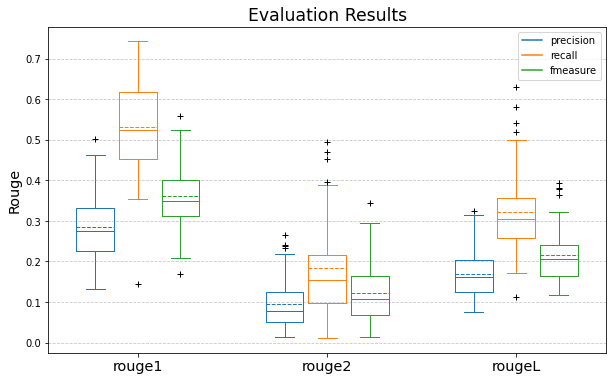

In [21]:
plot_evaluation('sshleifer/distilbart-cnn-12-6')

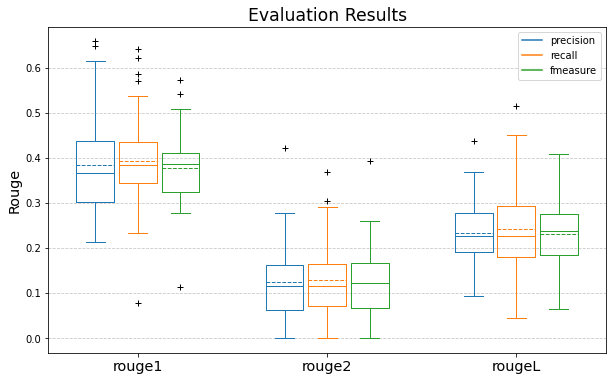

In [23]:
plot_evaluation(magma_dir+'fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_train/')

#### Plot Evaluation Bullet by Bullet

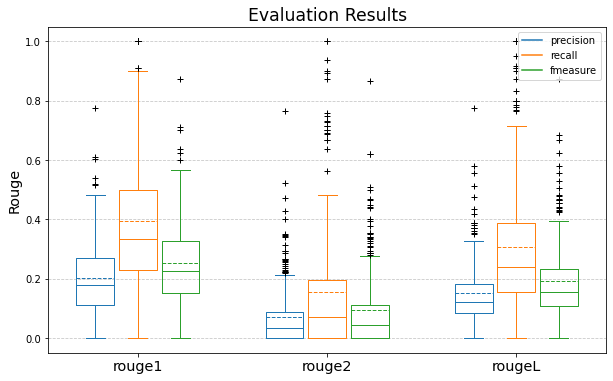

In [22]:
plot_evaluation_bullet_by_bullet('sshleifer/distilbart-cnn-12-6')

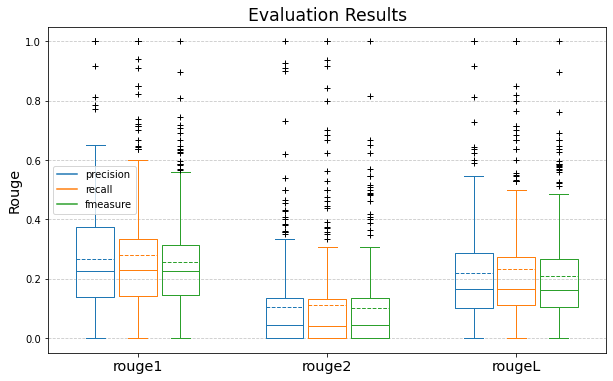

In [24]:
plot_evaluation_bullet_by_bullet(magma_dir+'fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_train/')

In [25]:
df_test

bullets  \
book          chapter                                                      
9781910797631 chp6     The treatment rather than the prevention of de...   
              chp6     For milder forms of depression, self-help, rel...   
              chp6     There are a range of treatments that may be ef...   
              chp6     Selective serotonin-reuptake inhibitor antidep...   
              chp6     Depression is complex, and understanding and h...   
...                                                                  ...   
9781908541680 ch_4     Obesity significantly affects cardiometabolic ...   
              ch_4     Lipid disorders and hypertension are exacerbat...   
              ch_4     Weight loss rapidly and effectively reduces ca...   
              ch_4     The metabolic syndrome defines the clustering ...   
              ch_4     Type 2 diabetes mellitus is the comorbidity mo...   

                                                                    text  \
book          chapter                                                      
9781910797631 chp6     Prevention and management. By far the most res...   
              chp6     The forms of psychological therapy best suppor...   
              chp6     The effectiveness of individual treatments is ...   
              chp6     Monitoring use of antidepressants. For people ...   
              chp6     Suicidal ideas and acts may be increased in th...   
...                                                                  ...   
9781908541680 ch_4     Overweight/obesity as a whole predisposes to, ...   
              ch_4     Overweight/obesity as a whole predisposes to, ...   
              ch_4     Overweight/obesity as a whole predisposes to, ...   
              ch_4     'Metabolic syndrome' describes the clustering ...   
              ch_4     Type 2 diabetes mellitus is a preventable dise...   

                       num_bulls  \
book          chapter              
9781910797631 chp6          2319   
              chp6          2319   
              chp6          2319   
              chp6          2319   
              chp6          2319   
...                          ...   
9781908541680 ch_4          2556   
              ch_4          2556   
              ch_4          2556   
              ch_4          2556   
              ch_4          2556   

                                   summary_sshleifer/distilbart-cnn-12-6  \
book          chapter                                                      
9781910797631 chp6      Preventive strategies may be directed toward ...   
              chp6      The forms of psychological therapy best suppo...   
              chp6      Current evidence suggests that better outcome...   
              chp6      Many people discontinue their antidepressant ...   
              chp6      Suicidal ideas and acts may be increased in t...   
...                                                                  ...   
9781908541680 ch_4      Obesity is associated with hypertension, tach...   
              ch_4      Obesity is associated with hypertension, tach...   
              ch_4      Obesity is associated with hypertension, tach...   
              ch_4      The International Diabetes Federation updated...   
              ch_4      A modest reduction in weight by intensive lif...   

                      summary_/home/marco/epfl/magma/fine-tuning/sshleifer?distilbart-cnn-12-6_karger_books_para_wordembed_train/  
book          chapter                                                                                                              
9781910797631 chp6     Prevention and management of depression may be...                                                           
              chp6     The forms of psychological therapy best suppor...                                                           
              chp6     Stepped care is a model of healthcare based on...                             